# <center>Timeseries Dataset future prediction </center>
# <center>Univariate case LSTM vs Dense </center>

Dataset used: "jena_climate_2009_2016.csv" for Temperature prediction

<a name="id8"></a>
**Studied configurations:**

1. [LSTM 3x128](#id1)
2. [LSTM 1x32](#id2)
3. [Dense 3x128](#id3)
4. [Dense 1x32](#id4)
5. [ML conventional](#id5)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from zipfile import ZipFile
import os
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
uri = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
zip_path = keras.utils.get_file(origin=uri, fname="jena_climate_2009_2016.csv.zip")
zip_file = ZipFile(zip_path)
zip_file.extractall()
csv_path = "jena_climate_2009_2016.csv"

df = pd.read_csv(csv_path)

13574144/13568290 [==============================] - 0s 0us/step


In [3]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [4]:
# Sub-sampling: 1 every 6
# We go from 420.000 samples, 1 every 10 min, to 70.000 samples, 1 per hour
step = 6
a = range(0,len(df),step)

sub_df = pd.DataFrame(df, index=a)
sub_df = sub_df.reset_index(drop=True)
sub_df.shape

(70092, 15)

In [5]:
# univariate dataframe: Temp vs Time
uni_data_df = sub_df['T (degC)']           # variable
uni_data_df.index = sub_df['Date Time']    # index
uni_data_df.shape

(70092,)

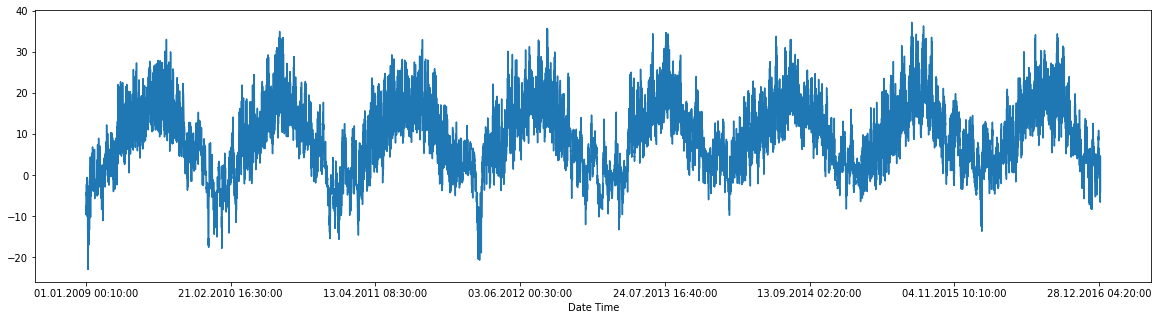

In [6]:
uni_data_df.plot(figsize=(20,5))

In [7]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    """function to create input and ouput values for univariate time series forecasting"""
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size-1])
    
    return np.array(data), np.array(labels)

In [8]:
# First 80% obs will be used as train data and rest as test data.
TRAIN_SPLIT = int(0.8*uni_data_df.shape[0]) 

# Normalize data
uni_train_mean = uni_data_df[:TRAIN_SPLIT].mean()
uni_train_std = uni_data_df[:TRAIN_SPLIT].std()
uni_data = (uni_data_df-uni_train_mean)/uni_train_std

In [9]:
# Use the above function to create the datasets.
# Creating the time windows
past_history = 120  # using 120 hours historical data
future_target = 12  # we want to predict 6 hours in the future


x_train_3D, y_train = univariate_data(uni_data.values, 0, TRAIN_SPLIT,
                                        past_history,
                                        future_target)
x_val_3D, y_val = univariate_data(uni_data.values, TRAIN_SPLIT, None,
                                    past_history,
                                    future_target)

In [10]:
x_train_3D.shape, y_train.shape

((55953, 120, 1), (55953,))

In [11]:
x_val_3D.shape, y_val.shape

((13887, 120, 1), (13887,))

<a name="id1"></a>
## LSTM 3x128


In [ ]:
# Building a 3 layer 128 neurons LSTM model
# Important:  Next layer needs the complete temporal sequence
# therefore return_sequences=True
layered_lstm_model = Sequential()
layered_lstm_model.add(LSTM(128, input_shape=x_train_3D.shape[-2:], return_sequences=True))
layered_lstm_model.add(LSTM(128, return_sequences=True))
layered_lstm_model.add(LSTM(128, return_sequences=False))
layered_lstm_model.add(Dense(1))

layered_lstm_model.compile(optimizer='adam', loss='mse', metrics=['mae']) 


In [ ]:
layered_lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 120, 128)          66560     
_________________________________________________________________
lstm_1 (LSTM)                (None, 120, 128)          131584    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 329,857
Trainable params: 329,857
Non-trainable params: 0
_________________________________________________________________


In [ ]:
nEpochs = 15
batchSize = 256
call_stop_early = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)
call_model_checkp = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)
calls = [call_stop_early, call_model_checkp]
    
lhistory=layered_lstm_model.fit(x_train_3D, y_train, 
                              epochs=nEpochs, batch_size=batchSize, 
                              verbose=1,
                              validation_data = (x_val_3D, y_val),
                              callbacks=calls)

Epoch 1/15
219/219 [==============================] - 9s 42ms/step - loss: 0.0210 - mae: 0.1105 - val_loss: 0.1525 - val_mae: 0.3020
Epoch 2/15
219/219 [==============================] - 9s 42ms/step - loss: 0.0192 - mae: 0.1058 - val_loss: 0.1572 - val_mae: 0.3067
Epoch 3/15
219/219 [==============================] - 9s 42ms/step - loss: 0.0169 - mae: 0.0992 - val_loss: 0.1621 - val_mae: 0.3117
Epoch 4/15
219/219 [==============================] - 9s 42ms/step - loss: 0.0150 - mae: 0.0937 - val_loss: 0.1623 - val_mae: 0.3125
Epoch 5/15
219/219 [==============================] - 9s 42ms/step - loss: 0.0133 - mae: 0.0881 - val_loss: 0.1615 - val_mae: 0.3109
Epoch 6/15
219/219 [==============================] - 9s 42ms/step - loss: 0.0124 - mae: 0.0854 - val_loss: 0.1637 - val_mae: 0.3140
Epoch 00006: early stopping


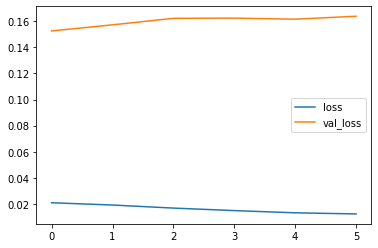

In [ ]:
plt.plot(lhistory.history['loss'])
plt.plot(lhistory.history['val_loss'])
plt.legend(('loss', 'val_loss'))
plt.show()

In [ ]:
#NN model accuracy 
lypred = layered_lstm_model.predict(x_train_3D)
lyhat = layered_lstm_model.predict(x_val_3D)

print("\nLSTM NN model\n")
print("Training accuracy: ", r2_score(y_train, lypred))
print("Test accuracy: ", r2_score(y_val, lyhat))



Modelo NN

Precisión de entrenamiento:  0.9887760255930081
Precisión de test:  0.8231158480256401


In [ ]:
lyhat_n = lyhat * uni_train_std + uni_train_mean
y_val_n = y_val * uni_train_std + uni_train_mean

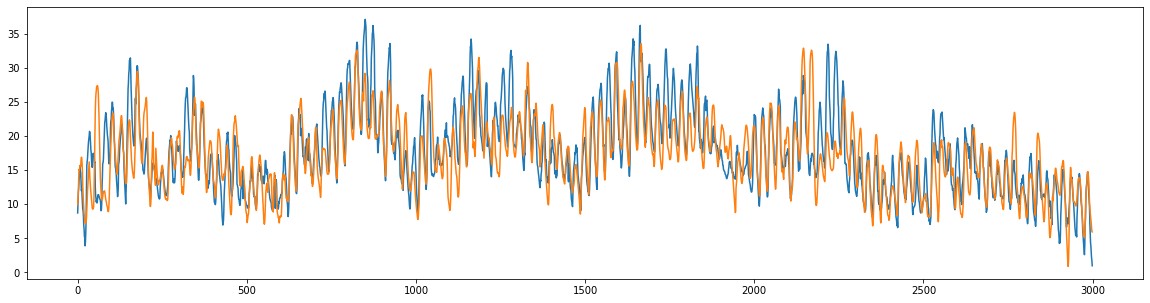

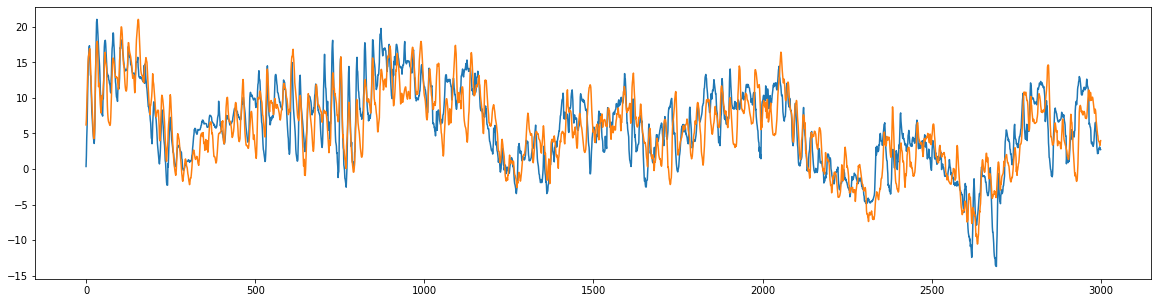

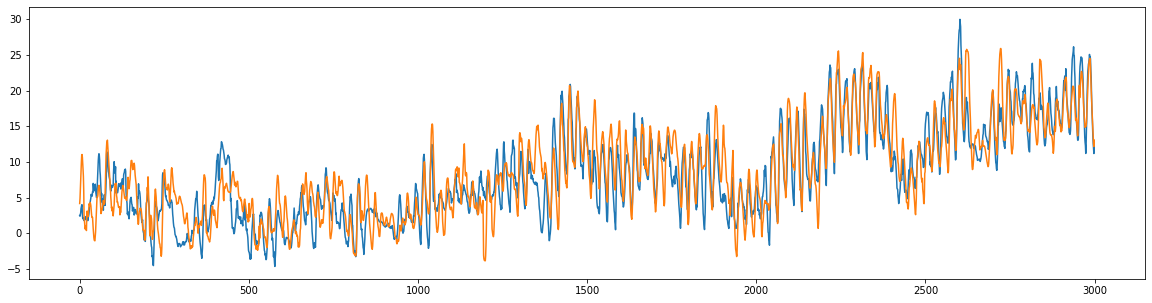

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(y_val_n[0:3000])
plt.plot(lyhat_n[0:3000])

plt.figure(figsize=(20,5))
plt.plot(y_val_n[3000:6000])
plt.plot(lyhat_n[3000:6000])

plt.figure(figsize=(20,5))
plt.plot(y_val_n[6000:9000])
plt.plot(lyhat_n[6000:9000])

<a name="id2"></a>
## LSTM 1x32

In [ ]:
# Building a 1 layer 32 neurons LSTM model
simple_lstm_model = Sequential()
simple_lstm_model.add(LSTM(32, input_shape=x_train_3D.shape[-2:]))
simple_lstm_model.add(Dense(1))

simple_lstm_model.compile(optimizer='adam', loss='mse', metrics=['mae']) 


In [ ]:
nEpochs = 50
batchSize = 16
call_stop_early = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)
call_model_checkp = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)
calls = [call_stop_early, call_model_checkp]
    
history=simple_lstm_model.fit(x_train_3D, y_train, 
                              epochs=nEpochs, batch_size=batchSize, 
                              verbose=1,
                              validation_data = (x_val_3D, y_val),
                              callbacks=calls)

Epoch 1/50
3498/3498 [==============================] - 22s 6ms/step - loss: 0.0985 - mae: 0.2438 - val_loss: 0.1103 - val_mae: 0.2580
Epoch 2/50
3498/3498 [==============================] - 22s 6ms/step - loss: 0.0972 - mae: 0.2422 - val_loss: 0.1057 - val_mae: 0.2527
Epoch 3/50
3498/3498 [==============================] - 22s 6ms/step - loss: 0.0975 - mae: 0.2428 - val_loss: 0.1084 - val_mae: 0.2557
Epoch 4/50
3498/3498 [==============================] - 22s 6ms/step - loss: 0.0960 - mae: 0.2412 - val_loss: 0.1122 - val_mae: 0.2605
Epoch 5/50
3498/3498 [==============================] - 23s 7ms/step - loss: 0.0954 - mae: 0.2405 - val_loss: 0.1101 - val_mae: 0.2587
Epoch 6/50
3498/3498 [==============================] - 24s 7ms/step - loss: 0.0943 - mae: 0.2389 - val_loss: 0.1113 - val_mae: 0.2586
Epoch 7/50
3498/3498 [==============================] - 24s 7ms/step - loss: 0.0935 - mae: 0.2376 - val_loss: 0.1129 - val_mae: 0.2602
Epoch 8/50
3498/3498 [==============================] -

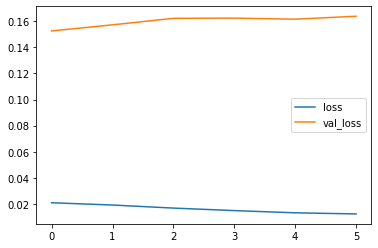

In [ ]:
plt.plot(lhistory.history['loss'])
plt.plot(lhistory.history['val_loss'])
plt.legend(('loss', 'val_loss'))
plt.show()

In [ ]:
#NN model accuracy 
ypred = simple_lstm_model.predict(x_train_3D)
yhat = simple_lstm_model.predict(x_val_3D)

print("\nLSTM NN model\n")
print("Training accuracy: ", r2_score(y_train, ypred))
print("Test accuracy: ", r2_score(y_val, yhat))



Modelo NN

Precisión de entrenamiento:  0.9086129742049021
Precisión de test:  0.8808904524439453


In [ ]:
yhat_n = yhat * uni_train_std + uni_train_mean
y_val_n = y_val * uni_train_std + uni_train_mean

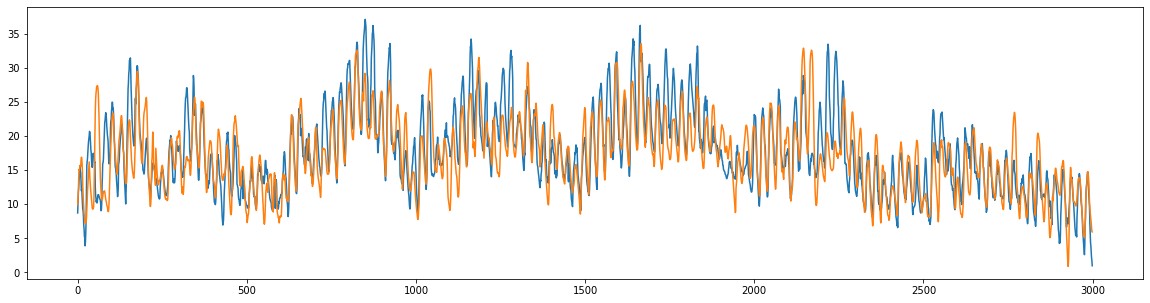

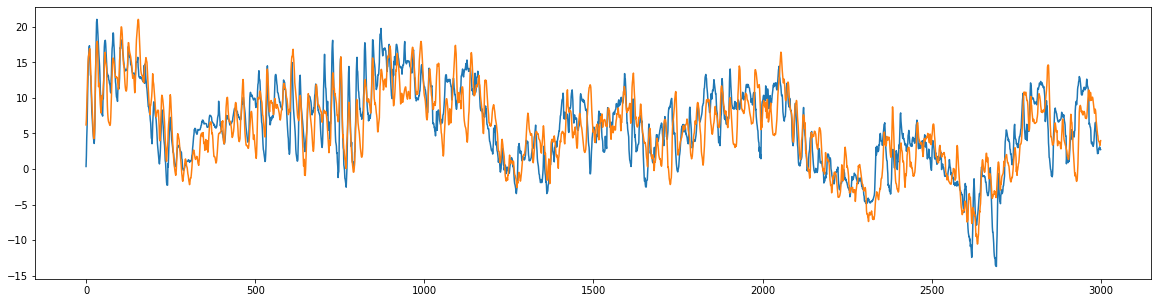

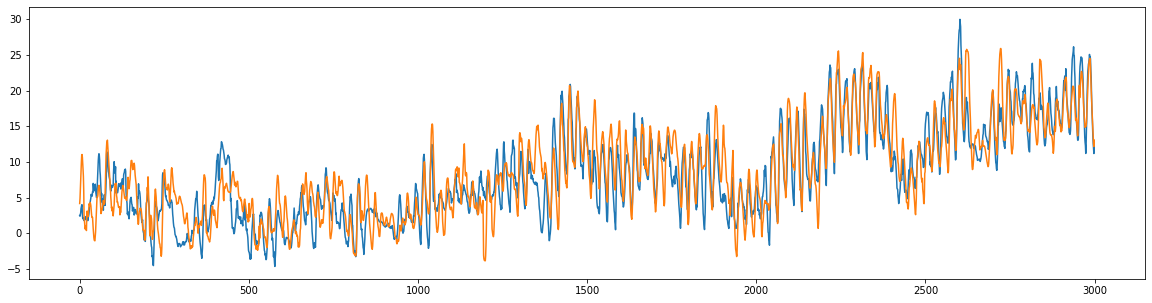

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(y_val_n[0:3000])
plt.plot(lyhat_n[0:3000])

plt.figure(figsize=(20,5))
plt.plot(y_val_n[3000:6000])
plt.plot(lyhat_n[3000:6000])

plt.figure(figsize=(20,5))
plt.plot(y_val_n[6000:9000])
plt.plot(lyhat_n[6000:9000])

<a name="id3"></a>
## NN Dense 3x128

#### Use my library

In [12]:
from sklearn.model_selection import train_test_split, ParameterGrid


In [15]:
from google.colab import drive
drive.mount('/content/drive/')

import os
os.chdir("/content/drive/My Drive/Colab Notebooks")
!ls
from Rober_library import Optimize_parameters_RegrNN_BF, Create_Train_RegrNN, plotHistory

Mounted at /content/drive/
 best_model.h5				'NN hiperparametros II.ipynb'
'Importar Rober_library Colab.ipynb'	 __pycache__
'LSTM NN multivariate multistep.ipynb'	 Rober_library.ipynb
'LSTM univariate.ipynb'			 Rober_library.py
'Neural Net telecust uso de GPU.ipynb'


In [13]:
# We need to flatten current data to use it as an input for a Dense network, as it has 1 more dimension than usual, time
train_flat = x_train_3D.reshape(x_train_3D.shape[0], x_train_3D.shape[1])
test_flat = x_val_3D.reshape(x_val_3D.shape[0], x_val_3D.shape[1])

In [ ]:
########################################################################
## Optimizing hyperparameters
## Hyperparameters Grid 
# ==============================================================================
param_grid = ParameterGrid({
                 'capas':[3],
                 'neuronas': [128],
                 'epochs_ini': [50],
                 'batch_ini':[512, 128, 32, 16], 
                 'activ_entr': ['selu'],
                 'activ_hid'   : ['sigmoid'],
                 #'activ_entr': ['relu', 'selu', 'tanh'],
                 #'activ_hid'   : ['relu', 'sigmoid'],
                 'optimiser_mio'   : ['adam']
                })

Epoch 1/50
110/110 [==============================] - 1s 4ms/step - loss: 0.2340 - mae: 0.3583 - val_loss: 0.1409 - val_mae: 0.2913
Epoch 2/50
110/110 [==============================] - 0s 3ms/step - loss: 0.1273 - mae: 0.2768 - val_loss: 0.1244 - val_mae: 0.2745
Epoch 3/50
110/110 [==============================] - 0s 3ms/step - loss: 0.1210 - mae: 0.2703 - val_loss: 0.1197 - val_mae: 0.2707
Epoch 4/50
110/110 [==============================] - 0s 4ms/step - loss: 0.1178 - mae: 0.2669 - val_loss: 0.1205 - val_mae: 0.2702
Epoch 5/50
110/110 [==============================] - 0s 3ms/step - loss: 0.1177 - mae: 0.2672 - val_loss: 0.1177 - val_mae: 0.2676
Epoch 6/50
110/110 [==============================] - 0s 3ms/step - loss: 0.1154 - mae: 0.2644 - val_loss: 0.1188 - val_mae: 0.2702
Epoch 7/50
110/110 [==============================] - 0s 3ms/step - loss: 0.1126 - mae: 0.2610 - val_loss: 0.1158 - val_mae: 0.2674
Epoch 8/50
110/110 [==============================] - 0s 3ms/step - loss: 0.

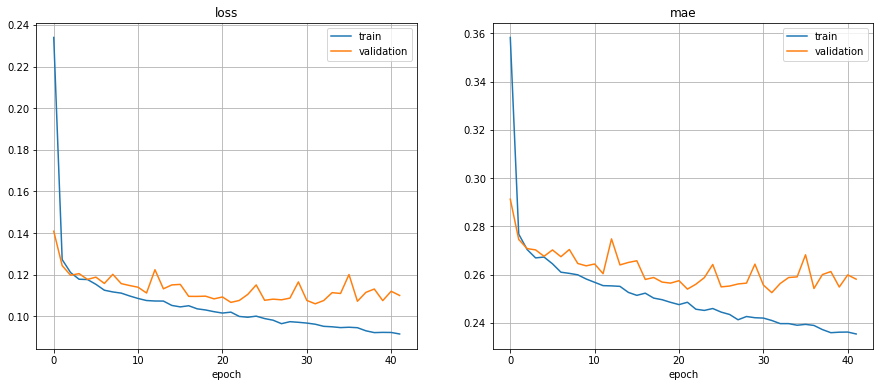

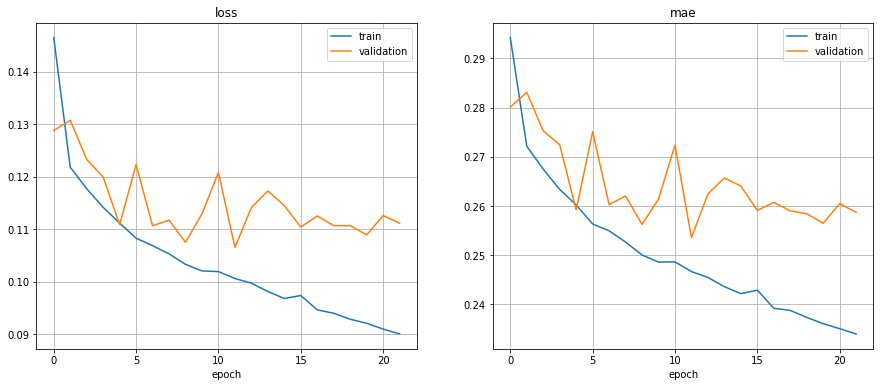

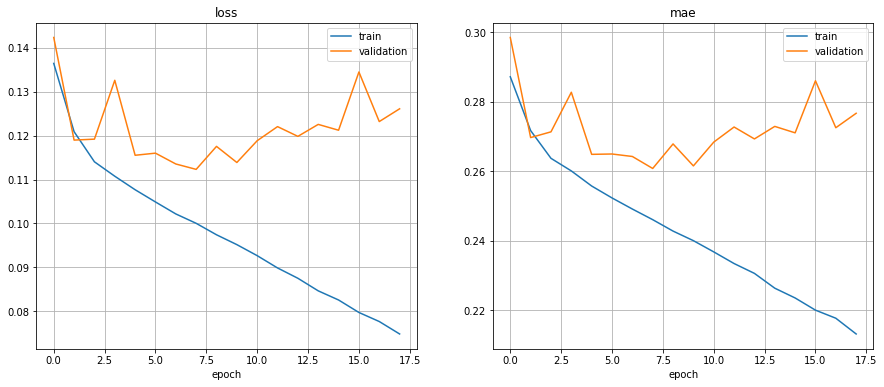

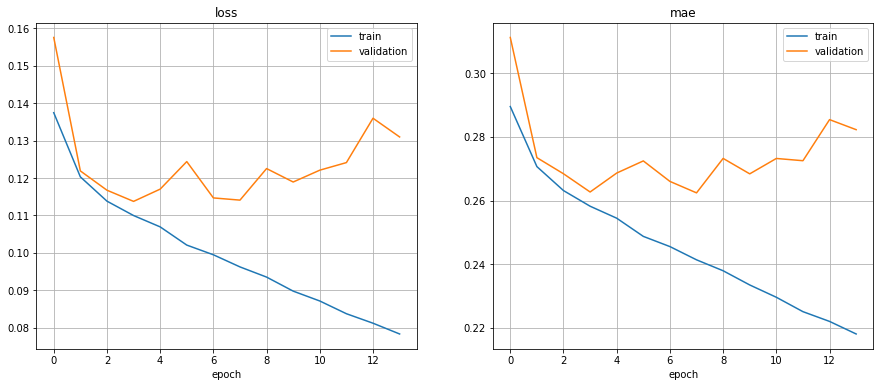

In [ ]:
# I use my function for optimizing hyperparameters in NN
lres, lhis = Optimize_parameters_RegrNN_BF(train_flat, y_train, test_flat, y_val, param_grid, stop=True)

In [ ]:
lres

,train_accuracy,test_accuracy,activ_entr,activ_hid,batch_ini,capas,epochs_ini,neuronas,optimiser_mio
0,0.910026,0.881124,selu,sigmoid,512,3,50,128,adam
1,0.913891,0.879935,selu,sigmoid,128,3,50,128,adam
2,0.925000,0.863769,selu,sigmoid,32,3,50,128,adam
3,0.923993,0.858525,selu,sigmoid,16,3,50,128,adam


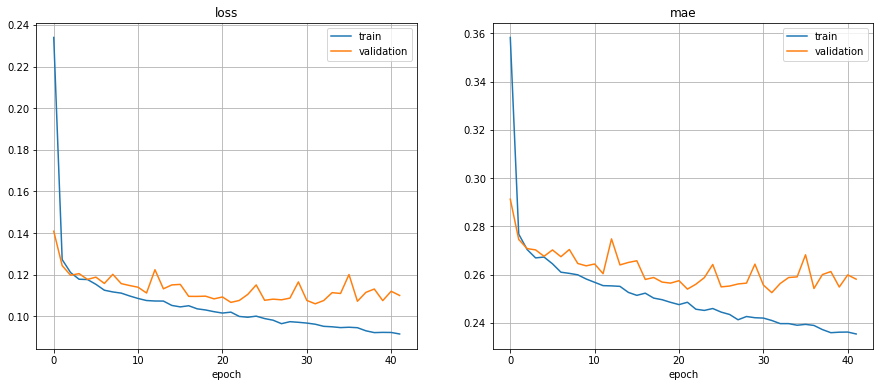

In [ ]:
#Best model plot
plotHistory(lhis[0])

Epoch 1/50
110/110 [==============================] - 1s 4ms/step - loss: 0.2410 - mae: 0.3634 - val_loss: 0.1374 - val_mae: 0.2855
Epoch 2/50
110/110 [==============================] - 0s 3ms/step - loss: 0.1274 - mae: 0.2770 - val_loss: 0.1298 - val_mae: 0.2823
Epoch 3/50
110/110 [==============================] - 0s 3ms/step - loss: 0.1212 - mae: 0.2704 - val_loss: 0.1236 - val_mae: 0.2754
Epoch 4/50
110/110 [==============================] - 0s 3ms/step - loss: 0.1191 - mae: 0.2684 - val_loss: 0.1212 - val_mae: 0.2713
Epoch 5/50
110/110 [==============================] - 0s 3ms/step - loss: 0.1163 - mae: 0.2654 - val_loss: 0.1199 - val_mae: 0.2697
Epoch 6/50
110/110 [==============================] - 0s 3ms/step - loss: 0.1153 - mae: 0.2641 - val_loss: 0.1296 - val_mae: 0.2835
Epoch 7/50
110/110 [==============================] - 0s 3ms/step - loss: 0.1144 - mae: 0.2631 - val_loss: 0.1173 - val_mae: 0.2666
Epoch 8/50
110/110 [==============================] - 0s 3ms/step - loss: 0.

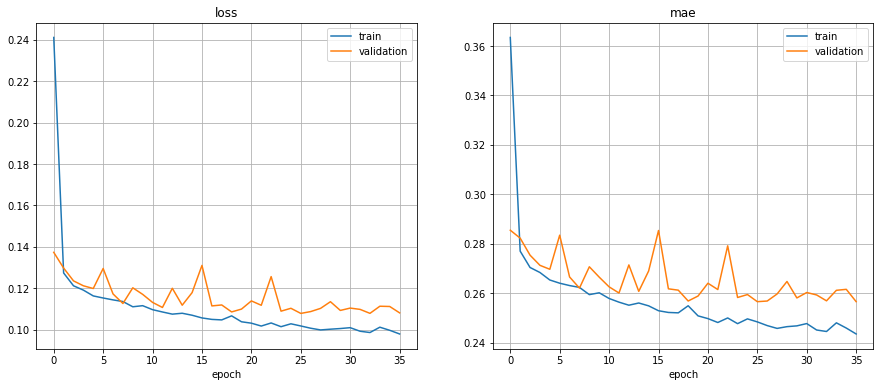

In [ ]:
model, hist = Create_Train_RegrNN(120, train_flat, y_train, test_flat, y_val, stop =True,
                                    capas=3, neuronas=128,
                                    epochs_ini=50, batch_ini=512,
                                     activ_entr='tanh',
                                     activ_hid='sigmoid')

In [ ]:
#NN model accuracy 
ypred = model.predict(train_flat)
yhat = model.predict(test_flat)

print("\nDense NN model\n")
print("Training accuracy: ", r2_score(y_train, ypred))
print("Test accuracy: ", r2_score(y_val, yhat))



Modelo NN

Precisión de entrenamiento:  0.9044482554167826
Precisión de test:  0.8831503994946974


In [ ]:
yhat_n = yhat * uni_train_std + uni_train_mean
y_val_n = y_val * uni_train_std + uni_train_mean

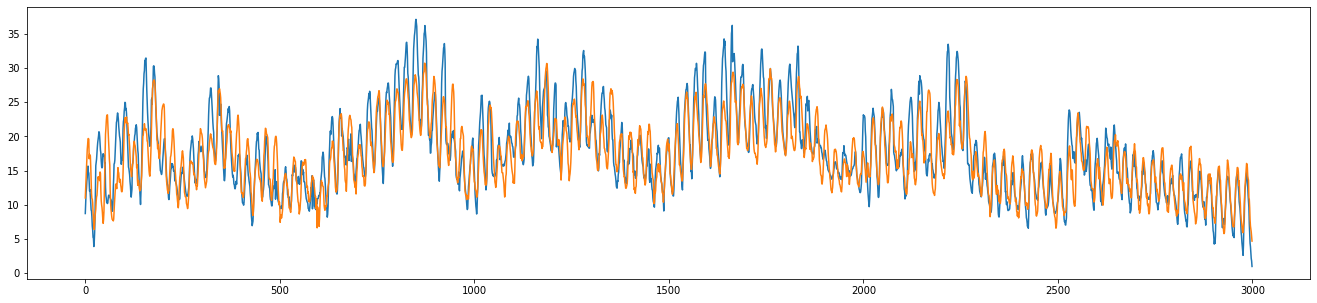

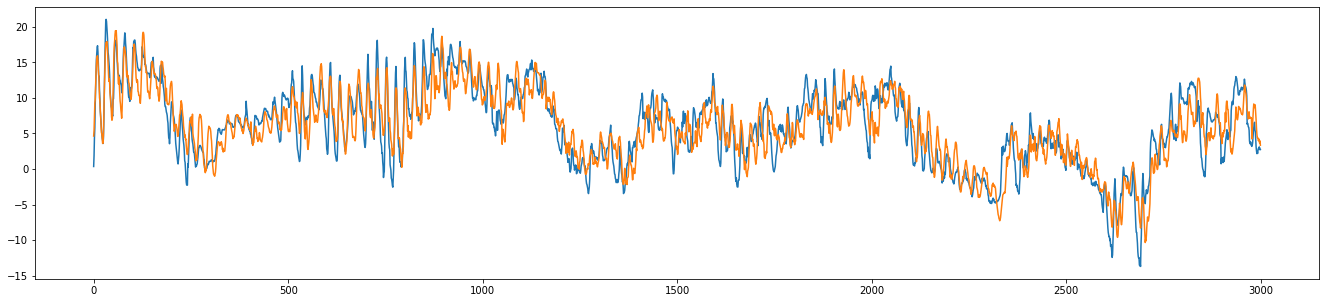

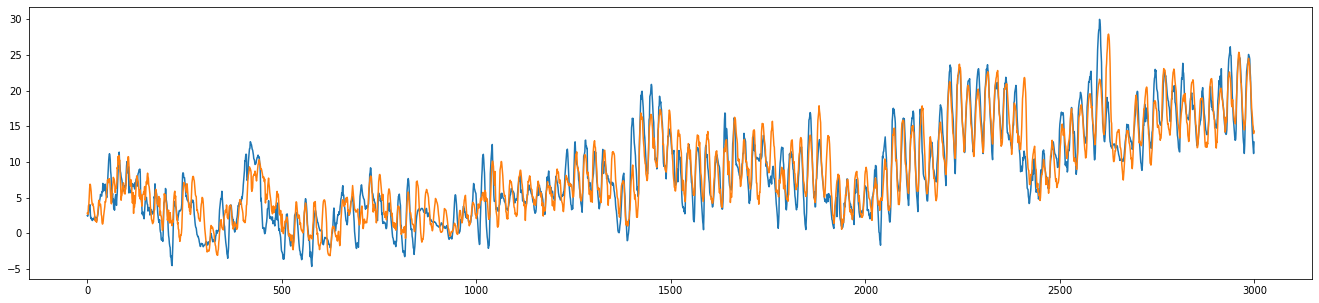

In [ ]:
plt.figure(figsize=(23,5))
plt.plot(y_val_n[0:3000])
plt.plot(yhat_n[0:3000])

plt.figure(figsize=(23,5))
plt.plot(y_val_n[3000:6000])
plt.plot(yhat_n[3000:6000])

plt.figure(figsize=(23,5))
plt.plot(y_val_n[6000:9000])
plt.plot(yhat_n[6000:9000])


<a name="id4"></a>
## NN Dense 1x32

#### Use my library

In [ ]:
########################################################################
## Optimizing hyperparameters
## Hyperparameters Grid 
# ==============================================================================
param_grid = ParameterGrid({
                 'capas':[1],
                 'neuronas': [32],
                 'epochs_ini': [50],
                 'batch_ini':[512, 128, 32, 16], 
                 'activ_entr': ['selu'],
                 'activ_hid'   : ['sigmoid'],
#                  'activ_entr': ['relu', 'selu', 'tanh'],
#                  'activ_hid'   : ['relu', 'sigmoid'],
                 'optimiser_mio'   : ['adam']
                })

In [ ]:
# We need to flatten current data to use it as an input for a Dense network, as it has 1 more dimension than usual, time
train_flat = x_train_3D.reshape(x_train_3D.shape[0], x_train_3D.shape[1])
test_flat = x_val_3D.reshape(x_val_3D.shape[0], x_val_3D.shape[1])

Epoch 1/50
110/110 [==============================] - 1s 4ms/step - loss: 0.2728 - mae: 0.3903 - val_loss: 0.1557 - val_mae: 0.3079
Epoch 2/50
110/110 [==============================] - 0s 3ms/step - loss: 0.1468 - mae: 0.2992 - val_loss: 0.1403 - val_mae: 0.2918
Epoch 3/50
110/110 [==============================] - 0s 3ms/step - loss: 0.1361 - mae: 0.2871 - val_loss: 0.1334 - val_mae: 0.2834
Epoch 4/50
110/110 [==============================] - 0s 3ms/step - loss: 0.1305 - mae: 0.2808 - val_loss: 0.1304 - val_mae: 0.2811
Epoch 5/50
110/110 [==============================] - 0s 3ms/step - loss: 0.1267 - mae: 0.2768 - val_loss: 0.1279 - val_mae: 0.2780
Epoch 6/50
110/110 [==============================] - 0s 3ms/step - loss: 0.1239 - mae: 0.2736 - val_loss: 0.1257 - val_mae: 0.2759
Epoch 7/50
110/110 [==============================] - 0s 3ms/step - loss: 0.1228 - mae: 0.2722 - val_loss: 0.1256 - val_mae: 0.2761
Epoch 8/50
110/110 [==============================] - 0s 3ms/step - loss: 0.

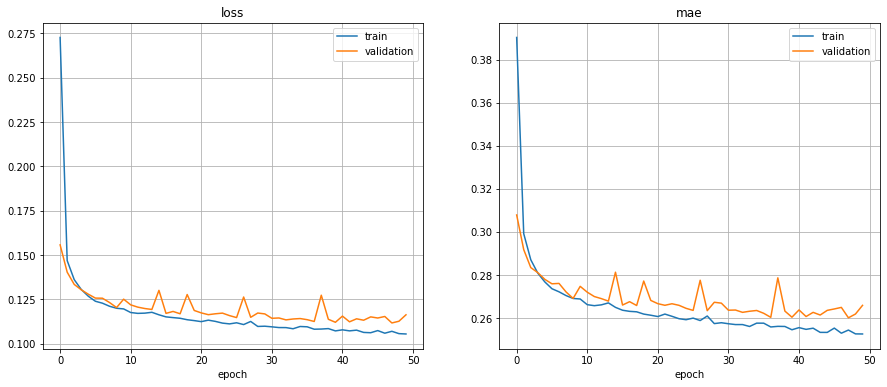

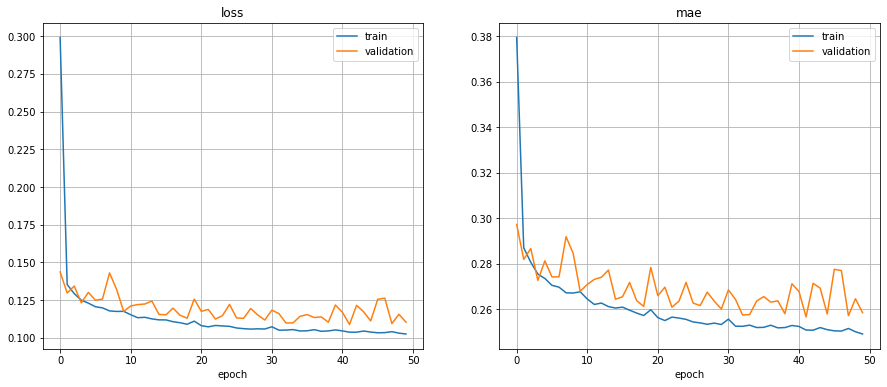

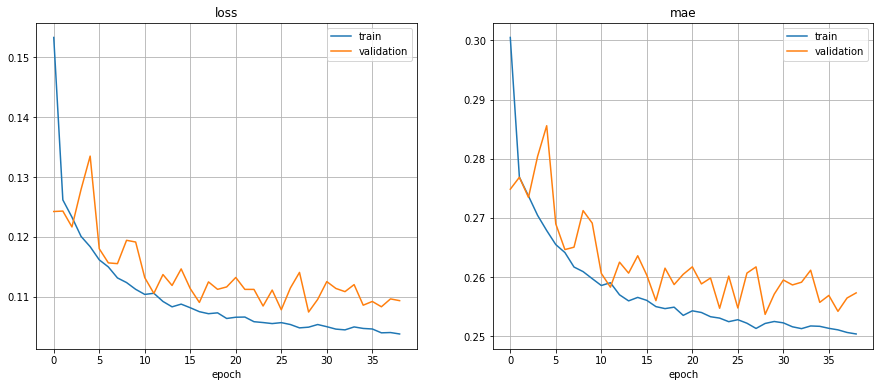

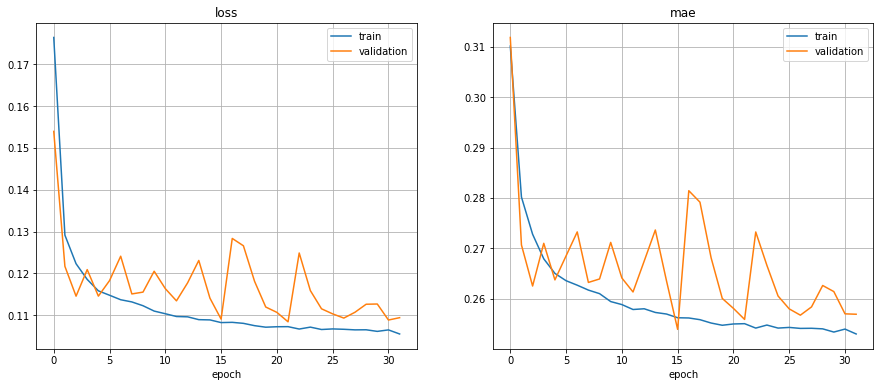

In [ ]:
# I use my function for optimizing hyperparameters in NN
lres, lhis = Optimize_parameters_RegrNN_BF(train_flat, y_train, test_flat, y_val, param_grid, stop=True)

In [ ]:
lres

,train_accuracy,test_accuracy,activ_entr,activ_hid,batch_ini,capas,epochs_ini,neuronas,optimiser_mio
0,0.899054,0.881869,selu,sigmoid,32,1,50,32,adam
1,0.895623,0.881821,selu,sigmoid,16,1,50,32,adam
2,0.898926,0.880840,selu,sigmoid,128,1,50,32,adam
3,0.891799,0.874422,selu,sigmoid,512,1,50,32,adam


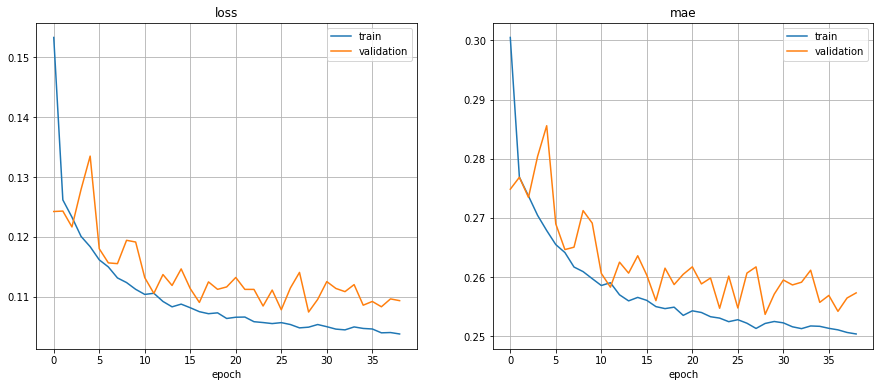

In [ ]:
#Best model plot
plotHistory(lhis[0])

Epoch 1/50
438/438 [==============================] - 1s 3ms/step - loss: 0.1366 - mae: 0.2877 - val_loss: 0.1232 - val_mae: 0.2734
Epoch 2/50
438/438 [==============================] - 1s 2ms/step - loss: 0.1225 - mae: 0.2725 - val_loss: 0.1360 - val_mae: 0.2883
Epoch 3/50
438/438 [==============================] - 1s 2ms/step - loss: 0.1191 - mae: 0.2686 - val_loss: 0.1229 - val_mae: 0.2744
Epoch 4/50
438/438 [==============================] - 1s 2ms/step - loss: 0.1163 - mae: 0.2653 - val_loss: 0.1196 - val_mae: 0.2709
Epoch 5/50
438/438 [==============================] - 1s 2ms/step - loss: 0.1145 - mae: 0.2633 - val_loss: 0.1248 - val_mae: 0.2768
Epoch 6/50
438/438 [==============================] - 1s 2ms/step - loss: 0.1134 - mae: 0.2621 - val_loss: 0.1168 - val_mae: 0.2676
Epoch 7/50
438/438 [==============================] - 1s 2ms/step - loss: 0.1117 - mae: 0.2601 - val_loss: 0.1253 - val_mae: 0.2775
Epoch 8/50
438/438 [==============================] - 1s 2ms/step - loss: 0.

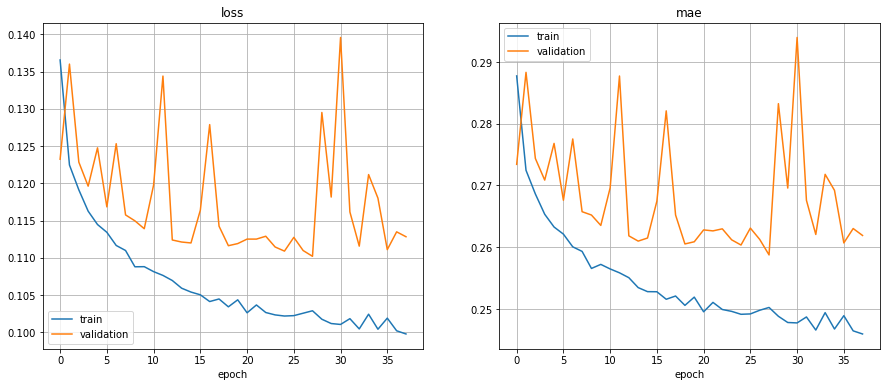

In [ ]:
model, hist = Create_Train_RegrNN(120, train_flat, y_train, test_flat, y_val, stop =True,
                                    capas=1, neuronas=32,
                                    epochs_ini=50, batch_ini=128,
                                     activ_entr='tanh',
                                     activ_hid='sigmoid')

In [ ]:
#NN model accuracy 
ypred = model.predict(train_flat)
yhat = model.predict(test_flat)

print("\nDense NN model\n")
print("Training accuracy: ", r2_score(y_train, ypred))
print("Test accuracy: ", r2_score(y_val, yhat))



Modelo NN

Precisión de entrenamiento:  0.9010362538848471
Precisión de test:  0.8781134609894031


In [ ]:
yhat_n = yhat * uni_train_std + uni_train_mean
y_val_n = y_val * uni_train_std + uni_train_mean

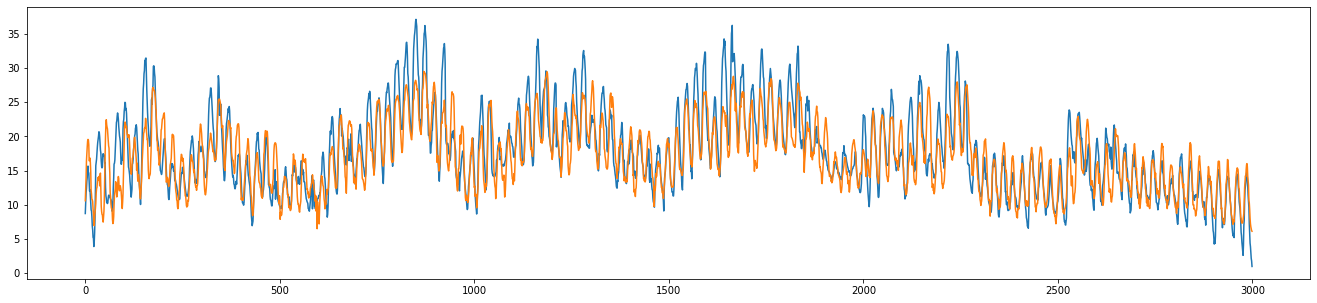

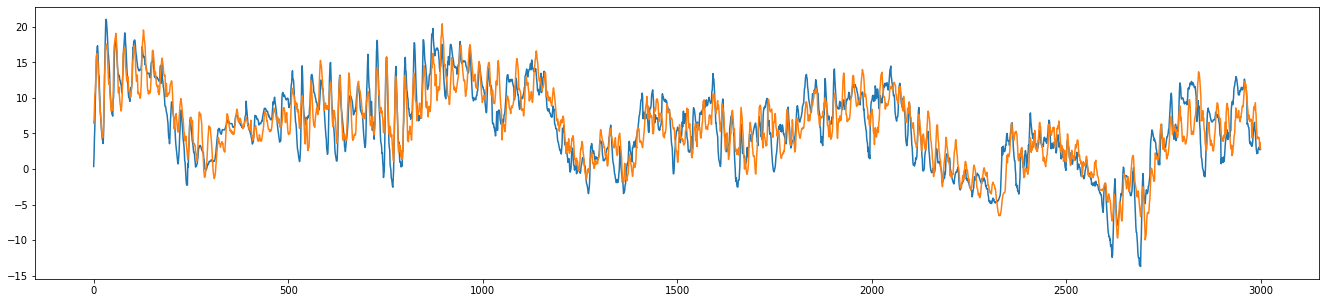

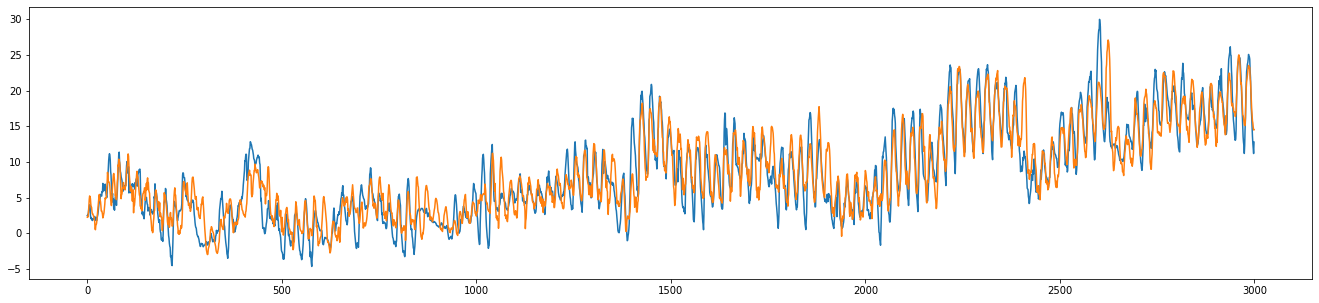

In [ ]:
plt.figure(figsize=(23,5))
plt.plot(y_val_n[0:3000])
plt.plot(yhat_n[0:3000])

plt.figure(figsize=(23,5))
plt.plot(y_val_n[3000:6000])
plt.plot(yhat_n[3000:6000])

plt.figure(figsize=(23,5))
plt.plot(y_val_n[6000:9000])
plt.plot(yhat_n[6000:9000])


<a name="id5"></a>
## ML conventional

#### Use my library

In [16]:
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import confusion_matrix, accuracy_score, r2_score, classification_report
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.svm import SVC, SVR
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor

from Rober_library import Optimize_parameters_BF

In [ ]:
modeloprueba = KNeighborsRegressor()

#KNN
param_grid = ParameterGrid(
                {'n_neighbors' : list(range(3,21,2)),
                 'weights'     : ['uniform','distance'],
                 'algorithm'   : ['auto', 'ball_tree', 'kd_tree', 'brute']
                })

res = Optimize_parameters_BF (modeloprueba, train_flat, y_train, test_flat, y_val, param_grid)

Modelo: {'algorithm': 'auto', 'n_neighbors': 3, 'weights': 'uniform'} ✓
Modelo: {'algorithm': 'auto', 'n_neighbors': 3, 'weights': 'distance'} ✓
Modelo: {'algorithm': 'auto', 'n_neighbors': 5, 'weights': 'uniform'} ✓
Modelo: {'algorithm': 'auto', 'n_neighbors': 5, 'weights': 'distance'} ✓
Modelo: {'algorithm': 'auto', 'n_neighbors': 7, 'weights': 'uniform'} ✓
Modelo: {'algorithm': 'auto', 'n_neighbors': 7, 'weights': 'distance'} ✓
Modelo: {'algorithm': 'auto', 'n_neighbors': 9, 'weights': 'uniform'} ✓
Modelo: {'algorithm': 'auto', 'n_neighbors': 9, 'weights': 'distance'} ✓
Modelo: {'algorithm': 'auto', 'n_neighbors': 11, 'weights': 'uniform'} ✓
Modelo: {'algorithm': 'auto', 'n_neighbors': 11, 'weights': 'distance'} ✓
Modelo: {'algorithm': 'auto', 'n_neighbors': 13, 'weights': 'uniform'} ✓
Modelo: {'algorithm': 'auto', 'n_neighbors': 13, 'weights': 'distance'} ✓
Modelo: {'algorithm': 'auto', 'n_neighbors': 15, 'weights': 'uniform'} ✓
Modelo: {'algorithm': 'auto', 'n_neighbors': 15, 'wei

In [ ]:
res

,accuracy,algorithm,n_neighbors,weights
0,0.833162,kd_tree,19,uniform
1,0.833162,ball_tree,19,uniform
2,0.833162,brute,19,uniform
3,0.833162,auto,19,uniform
4,0.832461,brute,19,distance
...,...,...,...,...
67,0.763100,kd_tree,3,uniform
68,0.762918,brute,3,distance
69,0.762918,kd_tree,3,distance
70,0.762918,auto,3,distance


In [ ]:
modeloprueba = DecisionTreeRegressor()

# Decision Tree
param_grid = ParameterGrid(
                {'max_features': ['auto','sqrt','log2'],
                 'criterion'   : [ 'mse','mae']
                })
res = Optimize_parameters_BF (modeloprueba, train_flat, y_train, test_flat, y_val, param_grid)

Modelo: {'criterion': 'mse', 'max_features': 'auto'} ✓
Modelo: {'criterion': 'mse', 'max_features': 'sqrt'} ✓
Modelo: {'criterion': 'mse', 'max_features': 'log2'} ✓
Modelo: {'criterion': 'mae', 'max_features': 'auto'} ✓
Modelo: {'criterion': 'mae', 'max_features': 'sqrt'} ✓
Modelo: {'criterion': 'mae', 'max_features': 'log2'} ✓


In [ ]:
res

,accuracy,criterion,max_features
0,0.752183,mse,auto
1,0.739523,mae,auto
2,0.729912,mse,sqrt
3,0.729131,mae,sqrt
4,0.726079,mse,log2
5,0.707688,mae,log2


In [ ]:
#Linear Regression
param_grid = ParameterGrid(
                {'normalize': [True, False]})

modeloprueba = LinearRegression()

res = Optimize_parameters_BF (modeloprueba, train_flat, y_train, test_flat, y_val, param_grid)

Modelo: {'normalize': True} ✓
Modelo: {'normalize': False} ✓


In [ ]:
res

,accuracy,normalize
0,0.872057,True
1,0.872057,False


In [ ]:
modeloprueba = SVR()

# SVM
param_grid = ParameterGrid(
                         {'kernel': ['linear','poly','rbf'],
                          'C'   : [ 0.1, 0.5]
                         })

res = Optimize_parameters_BF (modeloprueba, train_flat, y_train, test_flat, y_val, param_grid)

Modelo: {'C': 0.1, 'kernel': 'linear'} ✓
Modelo: {'C': 0.1, 'kernel': 'poly'} ✓
Modelo: {'C': 0.1, 'kernel': 'rbf'} ✓
Modelo: {'C': 0.5, 'kernel': 'linear'} ✓
Modelo: {'C': 0.5, 'kernel': 'poly'} ✓
Modelo: {'C': 0.5, 'kernel': 'rbf'} ✓


In [ ]:
res

,accuracy,C,kernel
0,0.875961,0.5,rbf
1,0.874696,0.1,rbf
2,0.872169,0.1,linear
3,0.872163,0.5,linear
4,0.670154,0.5,poly
5,0.626517,0.1,poly


In [ ]:
modeloprueba = RandomForestRegressor()

#Random Forest
param_grid = ParameterGrid(
                {'n_estimators': [10, 30],
                 'max_features': ['auto','sqrt','log2'],
                 'max_depth'   : [3, 20, 50],
                })

res = Optimize_parameters_BF (modeloprueba, train_flat, y_train, test_flat, y_val, param_grid)


Modelo: {'max_depth': 3, 'max_features': 'auto', 'n_estimators': 10} ✓
Modelo: {'max_depth': 3, 'max_features': 'auto', 'n_estimators': 30} ✓
Modelo: {'max_depth': 3, 'max_features': 'auto', 'n_estimators': 100} ✓
Modelo: {'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 10} ✓
Modelo: {'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 30} ✓
Modelo: {'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 100} ✓
Modelo: {'max_depth': 3, 'max_features': 'log2', 'n_estimators': 10} ✓
Modelo: {'max_depth': 3, 'max_features': 'log2', 'n_estimators': 30} ✓
Modelo: {'max_depth': 3, 'max_features': 'log2', 'n_estimators': 100} ✓
Modelo: {'max_depth': 20, 'max_features': 'auto', 'n_estimators': 10} ✓
Modelo: {'max_depth': 20, 'max_features': 'auto', 'n_estimators': 30} ✓
Modelo: {'max_depth': 20, 'max_features': 'auto', 'n_estimators': 100} ✓
Modelo: {'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 10} ✓
Modelo: {'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 30}

In [ ]:
res

,accuracy,max_depth,max_features,n_estimators
0,0.868894,20,auto,100
1,0.868677,50,auto,100
2,0.866387,50,auto,30
3,0.866000,20,auto,30
4,0.865989,50,sqrt,100
5,0.865463,20,sqrt,100
6,0.863658,50,log2,100
7,0.863010,20,log2,100
8,0.862574,50,sqrt,30
9,0.861528,20,sqrt,30


In [ ]:
modeloprueba = XGBRegressor()

#XGBoost
param_grid = ParameterGrid(
                {'n_estimators': [100, 500],
                 'learning_rate': [0.01, 0.05, 0.1],
                 'max_depth'   : [3, 7, 20],
                 'gamma' : [0.1]
                })

res = Optimize_parameters_BF (modeloprueba, train_flat, y_train, test_flat, y_val, param_grid)


[19:49:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Modelo: {'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100} ✓
[19:50:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Modelo: {'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500} ✓
[19:51:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Modelo: {'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 100} ✓
[19:52:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Modelo: {'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 500} ✓
[19:57:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Modelo: {'gamma': 0.1, 'l

In [ ]:
res

,accuracy,gamma,learning_rate,max_depth,n_estimators
0,0.871653,0.1,0.01,7.0,500.0
1,0.871270,0.1,0.10,3.0,500.0
2,0.870975,0.1,0.05,7.0,500.0
3,0.870890,0.1,0.05,7.0,100.0
4,0.870247,0.1,0.05,3.0,500.0
5,0.870139,0.1,0.10,7.0,100.0
6,0.868646,0.1,0.10,7.0,500.0
7,0.866125,0.1,0.01,20.0,500.0
8,0.865397,0.1,0.05,20.0,500.0
9,0.864981,0.1,0.05,20.0,100.0


# Plots with Linear regression prediction

In [17]:
model_lr = LinearRegression()

model_lr.fit(train_flat, y_train)
yhat_lr = model_lr.predict(test_flat)


In [18]:
yhat_n = yhat_lr * uni_train_std + uni_train_mean
y_val_n = y_val * uni_train_std + uni_train_mean

In [25]:
#NN model accuracy 
ypred = model_lr.predict(train_flat)

print("\nDense NN model\n")
print("Training accuracy: ", r2_score(y_train, ypred))
print("Test accuracy: ", r2_score(y_val, yhat_lr))


Dense NN model

Training accuracy:  0.8817141347424695
Test accuracy:  0.8720572272599263


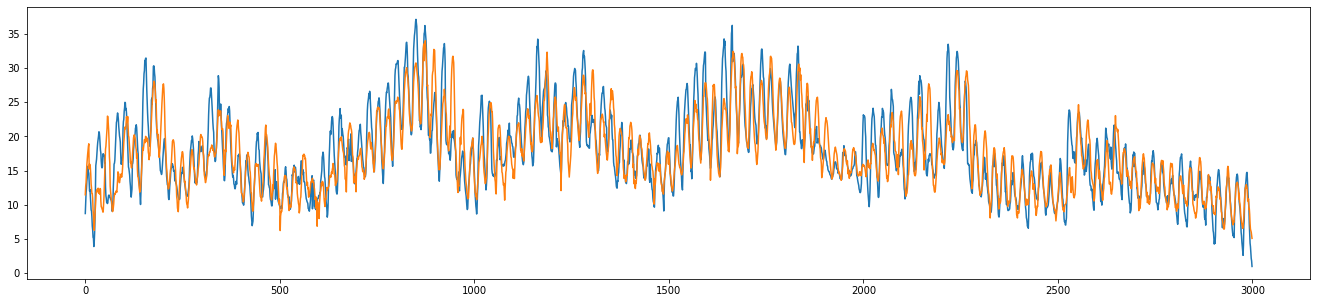

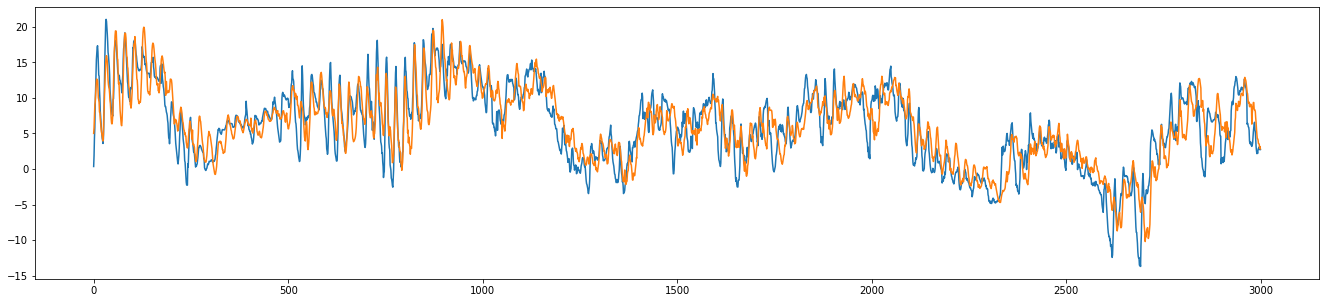

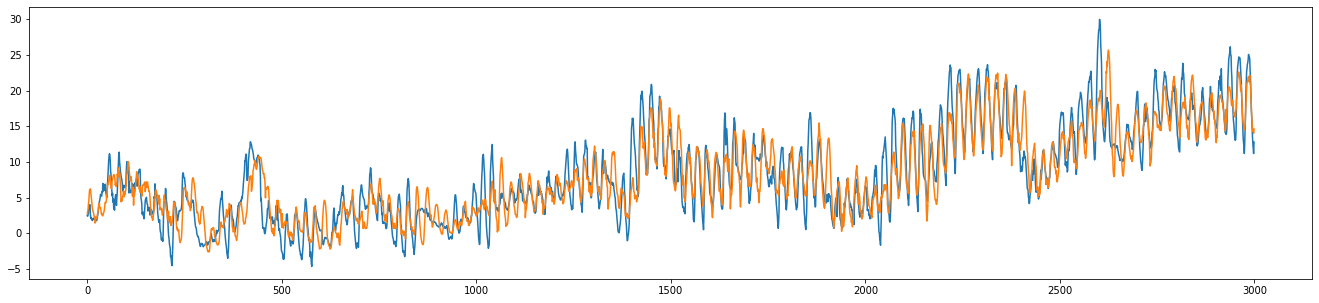

In [19]:
plt.figure(figsize=(23,5))
plt.plot(y_val_n[0:3000])
plt.plot(yhat_n[0:3000])

plt.figure(figsize=(23,5))
plt.plot(y_val_n[3000:6000])
plt.plot(yhat_n[3000:6000])

plt.figure(figsize=(23,5))
plt.plot(y_val_n[6000:9000])
plt.plot(yhat_n[6000:9000])

# Plots with SVM regression prediction

In [21]:
model_svr = SVR(kernel='rbf', C=0.5)

model_svr.fit(train_flat, y_train)
yhat_svr = model_svr.predict(test_flat)


In [22]:
yhat_n = yhat_svr * uni_train_std + uni_train_mean
y_val_n = y_val * uni_train_std + uni_train_mean

In [24]:
#NN model accuracy 
ypred = model_svr.predict(train_flat)

print("\nDense NN model\n")
print("Training accuracy: ", r2_score(y_train, ypred))
print("Test accuracy: ", r2_score(y_val, yhat_svr))



Dense NN model

Training accuracy:  0.9053013947009851
Test accuracy:  0.8759611291395261


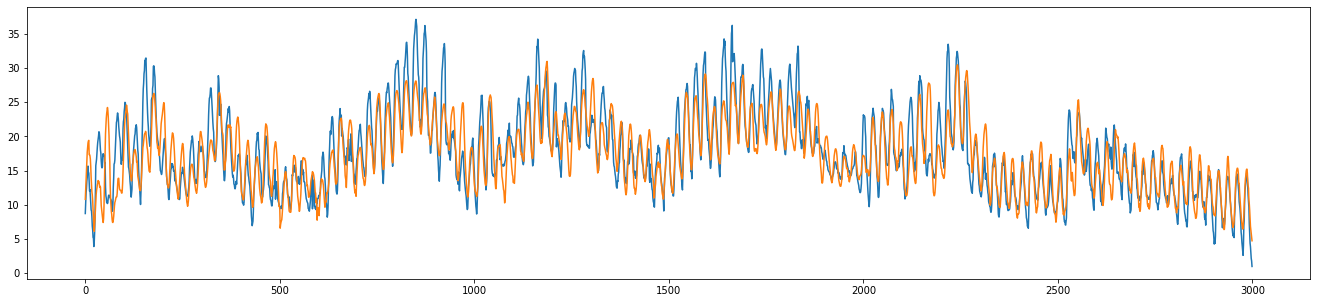

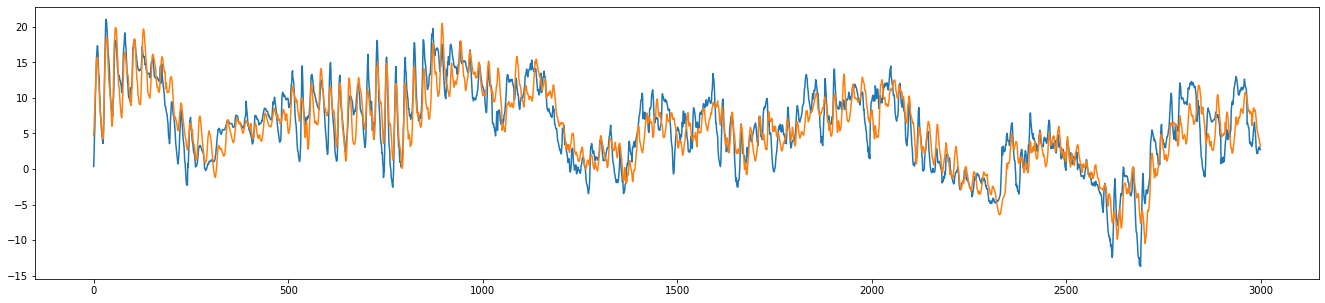

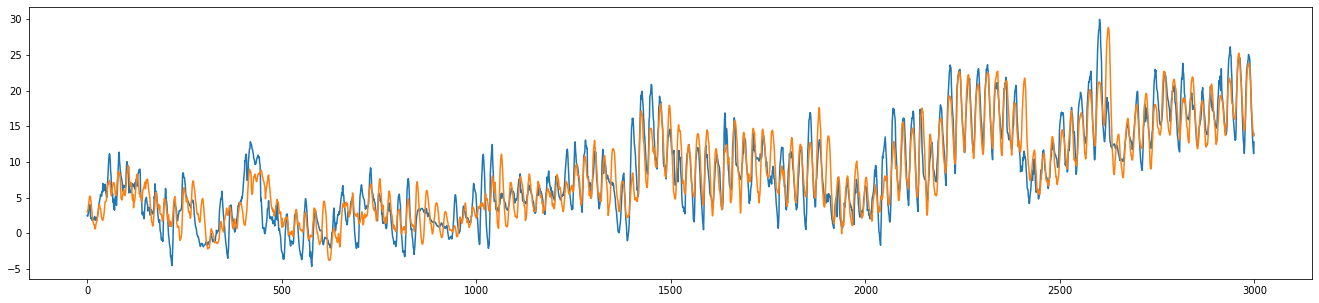

In [23]:
plt.figure(figsize=(23,5))
plt.plot(y_val_n[0:3000])
plt.plot(yhat_n[0:3000])

plt.figure(figsize=(23,5))
plt.plot(y_val_n[3000:6000])
plt.plot(yhat_n[3000:6000])

plt.figure(figsize=(23,5))
plt.plot(y_val_n[6000:9000])
plt.plot(yhat_n[6000:9000])

[Go to top](#id8)